<a href="https://colab.research.google.com/github/cesphamm/procesamiento_lenguaje_natural/blob/main/Desafio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Desafío 2: Custom embedddings con Gensim



1.   Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.
2.   Elegir términos de interés y buscar términos más similares y menos similares.
3. Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.
4. Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)




### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará el libro "El ingenioso caballero Don Quijote de la Mancha" para generar los embeddings, es decir, que los vectores tendrán la forma en función de cómo se usan las palabras en el libro de Cervantes.

Para realizar este desafío se obtuvieron los datos desde [Project Gutenberg](https://www.gutenberg.org/).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
try:
  from gensim.models import Word2Vec
except:
  !pip install gensim
  from gensim.models import Word2Vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 37.8 MB/s eta 0:00:00


### Datos
Utilizaremos como dataset canciones de bandas de habla inglesa.

In [18]:
import requests
import io

#url = "https://www.gutenberg.org/cache/epub/1533/pg1533.txt" # Macbeth
#url = "https://www.gutenberg.org/cache/epub/5200/pg5200.txt" # Metamorfosis
url = "https://www.gutenberg.org/cache/epub/996/pg996.txt" # Don Quijote

response = requests.get(url)
response.raise_for_status() # Raise an exception for HTTP errors

# Use io.StringIO to treat the text content as a file
df = pd.read_csv(io.StringIO(response.text), sep='/n', header=None, engine='python', on_bad_lines='skip')

print("First 5 rows of the DataFrame:")
print(df.head())
print("\nCantidad de documentos:", df.shape[0])

First 5 rows of the DataFrame:
                                                   0
0         The Project Gutenberg eBook of Don Quixote
1  This ebook is for the use of anyone anywhere i...
2  most other parts of the world at no cost and w...
3  whatsoever. You may copy it, give it away or r...
4  of the Project Gutenberg License included with...

Cantidad de documentos: 36470


### 1.   Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs o con alguno de los datsets de Project Gutenberg o Textos.info

#### 1.1 - Preprocesamiento

Transformo las oraciones en una secuencia de palabras.

In [7]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

texts = df.iloc[:, 0].astype(str).tolist()
sentence_tokens = [text_to_word_sequence(t) for t in texts]

In [8]:
sentence_tokens[:2]

[['the', 'project', 'gutenberg', 'ebook', 'of', 'don', 'quixote'],
 ['this',
  'ebook',
  'is',
  'for',
  'the',
  'use',
  'of',
  'anyone',
  'anywhere',
  'in',
  'the',
  'united',
  'states',
  'and']]

#### 1.2 - Crear los vectores (word2vec)

Instancio el modelo Word2Vec y construyo los tokens.

In [9]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [10]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [12]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 36470


In [13]:
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 5509


#### 1.3 - Entrenar embeddings

In [15]:
# Entrenamos el modelo generador de vectores
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 2918652.25
Loss after epoch 1: 2113045.25
Loss after epoch 2: 2018802.5
Loss after epoch 3: 1972103.0
Loss after epoch 4: 1906256.0
Loss after epoch 5: 1886842.0
Loss after epoch 6: 1866212.0
Loss after epoch 7: 1849574.0
Loss after epoch 8: 1792325.0
Loss after epoch 9: 1767586.0
Loss after epoch 10: 1752916.0
Loss after epoch 11: 1736550.0
Loss after epoch 12: 1721666.0
Loss after epoch 13: 1713784.0
Loss after epoch 14: 1699482.0
Loss after epoch 15: 1686558.0
Loss after epoch 16: 1681904.0
Loss after epoch 17: 1685022.0
Loss after epoch 18: 1782020.0
Loss after epoch 19: 1783680.0


(5769296, 8759440)

### 2. Elegir términos de interés y buscar términos más similares y menos similares

In [24]:
palabra = "windmills"
print(f"Palabras que MÁS se relacionan con {palabra}:")
print(w2v_model.wv.most_similar(positive=[palabra], topn=5))

print(f"Palabras que MENOS se relacionan con {palabra}:")
print(w2v_model.wv.most_similar(negative=[palabra], topn=5))

Palabras que MÁS se relacionan con windmills:
[('amadises', 0.7157620787620544), ('inhabitants', 0.7084283828735352), ('tombs', 0.6979909539222717), ('alcaldes', 0.685527503490448), ('clue', 0.6822073459625244)]
Palabras que MENOS se relacionan con windmills:
[('bear', -0.05882324278354645), ('thy', -0.07526947557926178), ('whose', -0.0809471607208252), ('herself', -0.0815761461853981), ('our', -0.09227456897497177)]


In [25]:
palabra = "dulcinea"
print(f"Palabras que MÁS se relacionan con {palabra}:")
print(w2v_model.wv.most_similar(positive=[palabra], topn=5))

print(f"Palabras que MENOS se relacionan con {palabra}:")
print(w2v_model.wv.most_similar(negative=[palabra], topn=5))

Palabras que MÁS se relacionan con dulcinea:
[('del', 0.6761146187782288), ('dulcinea’s', 0.6684761643409729), ('“dulcinea', 0.6270993947982788), ('campo', 0.6255802512168884), ('toboso', 0.6157054901123047)]
Palabras que MENOS se relacionan con dulcinea:
[('single', 0.005136896390467882), ('same', -0.01917215995490551), ('away', -0.02422552928328514), ('their', -0.043826982378959656), ('even', -0.049272321164608)]


In [26]:
palabra = "armour"
print(f"Palabras que MÁS se relacionan con {palabra}:")
print(w2v_model.wv.most_similar(positive=[palabra], topn=5))

print(f"Palabras que MENOS se relacionan con {palabra}:")
print(w2v_model.wv.most_similar(negative=[palabra], topn=5))

Palabras que MÁS se relacionan con armour:
[('shield', 0.6558501720428467), ('wrist', 0.6290474534034729), ('robe', 0.606614351272583), ('doublet', 0.6062020063400269), ('fist', 0.6051579713821411)]
Palabras que MENOS se relacionan con armour:
[('certain', 0.023810939863324165), ('much', 0.0022953632287681103), ('many', -0.002186114201322198), ('about', -0.007314169779419899), ('learned', -0.014944023452699184)]


In [28]:
palabra = "king"
print(f"Palabras que MÁS se relacionan con {palabra}:")
print(w2v_model.wv.most_similar(positive=[palabra], topn=5))

print(f"Palabras que MENOS se relacionan con {palabra}:")
print(w2v_model.wv.most_similar(negative=[palabra], topn=5))

Palabras que MÁS se relacionan con king:
[('lion', 0.5332704782485962), ('exploit', 0.5119621753692627), ('manuscript', 0.5088954567909241), ('marsilio', 0.5085862874984741), ('baptism', 0.501311182975769)]
Palabras que MENOS se relacionan con king:
[('silence', 0.03879997879266739), ('deep', 0.02419518679380417), ('fresh', 0.015530130825936794), ('other', 0.012386121787130833), ('these', 0.0053947013802826405)]


In [27]:
palabra = "sword"
print(f"Palabras que MÁS se relacionan con {palabra}:")
print(w2v_model.wv.most_similar(positive=[palabra], topn=5))

print(f"Palabras que MENOS se relacionan con {palabra}:")
print(w2v_model.wv.most_similar(negative=[palabra], topn=5))

Palabras que MÁS se relacionan con sword:
[('wrist', 0.6197771430015564), ('shield', 0.6023340225219727), ('girdle', 0.5944703817367554), ('cheek', 0.5880454182624817), ('buckler', 0.5812490582466125)]
Palabras que MENOS se relacionan con sword:
[('age', 0.004243526142090559), ('telling', -0.0004956691991537809), ('how', -0.004840405657887459), ('your', -0.005685079842805862), ('state', -0.007258047349750996)]


Resumen:

El modelo Word2Vec entrenado con el texto de "Don Quijote" captura eficazmente las relaciones semánticas según el libro. Para las palabras analizadas, el modelo identificó términos similares altamente relevantes y contextualmente apropiados.

Como puede observarse en los ejemplos para `dulcinea` identificó «dulcinea’s» y «toboso» dentro del top 5 más similares; para `armadura` identificó «escudo» y «túnica»; para `espada` identificó «escudo» y «broquel»; para `windmills` una de las palabras más similares fue «amadises», que viene de Amidís, el protagonista de la novela preferida de Don Quijote; para `king` la parabra más similar es «lion» y creo que puede deberse al capítulo donde Don Quijote quiere ennfrentar leones que eran llevados al rey para mostrar su valentía, y también tenemos a «Marsilio» que era rey de Zaragoza.

Esto indica que las representaciones vectoriales reflejan cómo se usan estas palabras en la novela. Los términos menos similares mostraron consistentemente puntuaciones de similitud bajas o negativas, lo que indica un uso contextual distinto dentro del corpus.

### 3. Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.

Se elige MAX_WORDS=300 para que sean visibles algunas agrupaciones, pero sigan siendo visibles las palabras también.

In [29]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [34]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=300
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab")

### 4. Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

En el primer grupo podemos observar `lugares` reales o que Don Quijote imagina en su aventura:

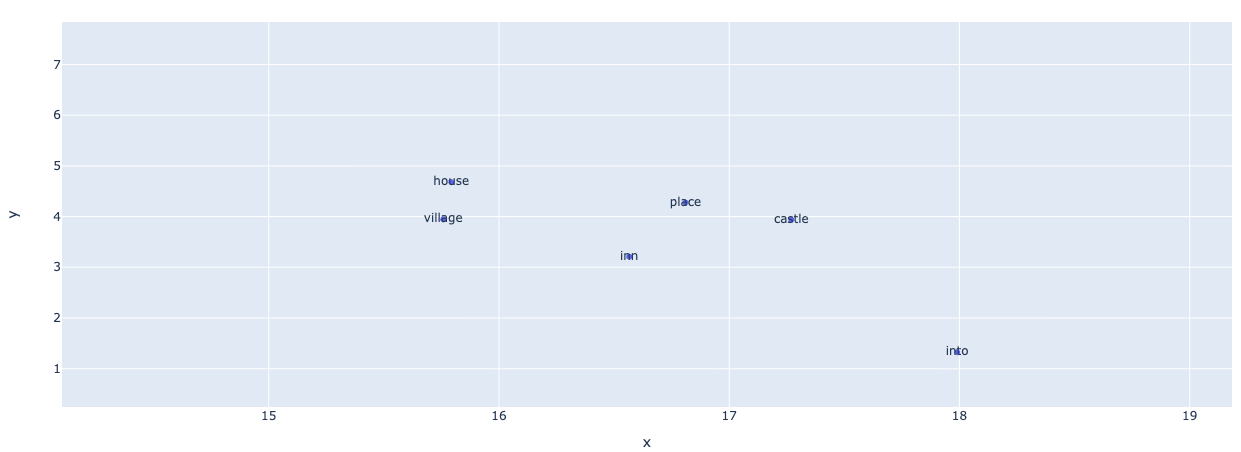

El segundo grupo corresponde a palabras relacionadas a la `caballería` de lo cual se habla a lo largo de todo el libro, ya que, ser un caballero errante es el sueño de Don Quijote.

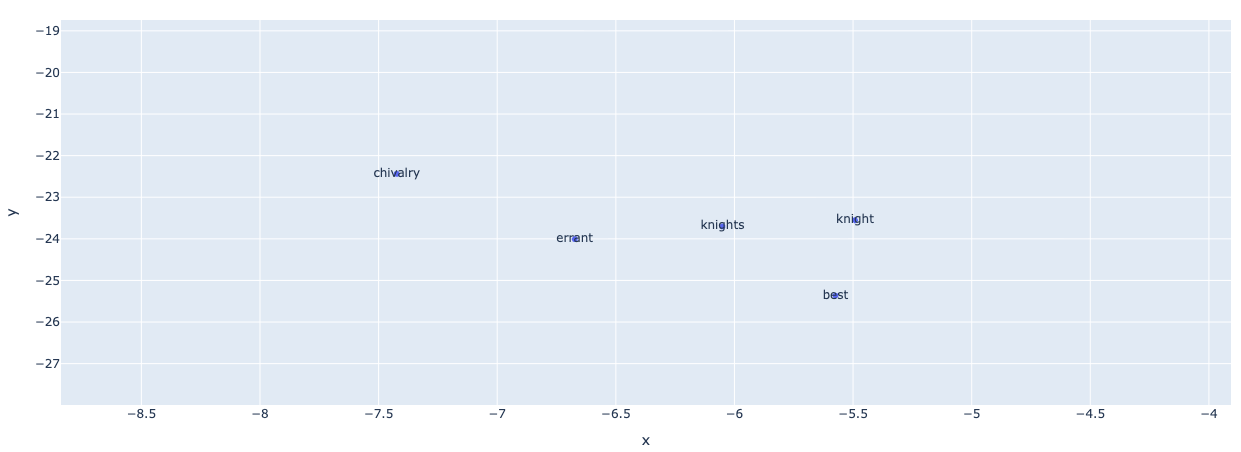

Verbos usados en diálogos en cualquier novela:

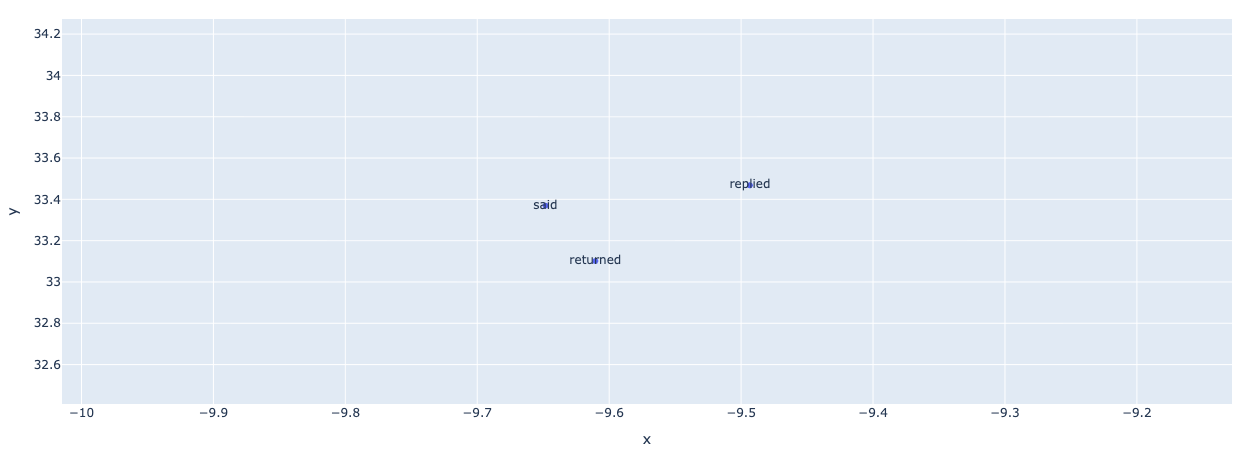

Palabras que pueden usarse como conectores conjuntivos, por lo que sus contextos pueden ser parecidos:

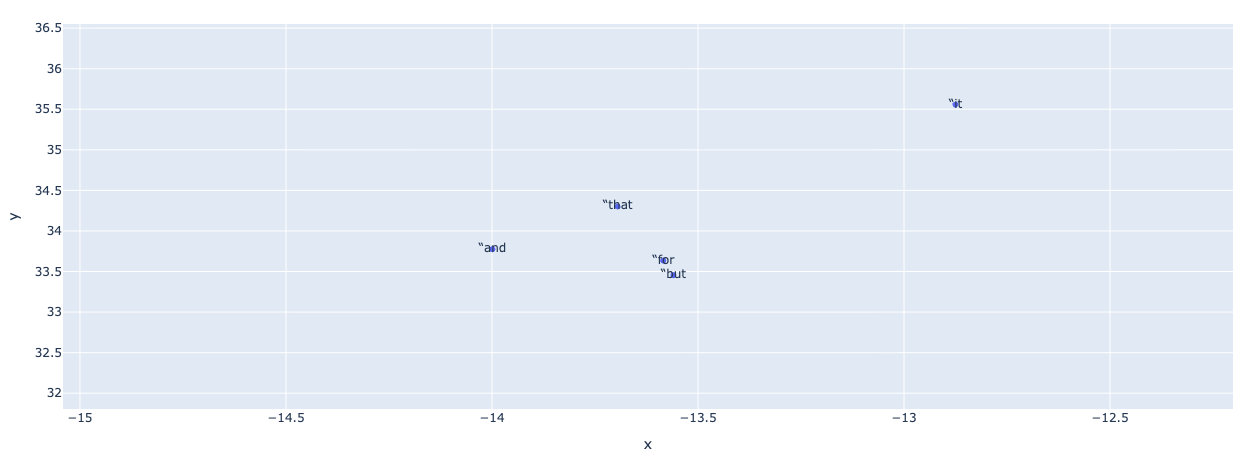

Los `verbos modales` suelen usarse en contextos parecidos:

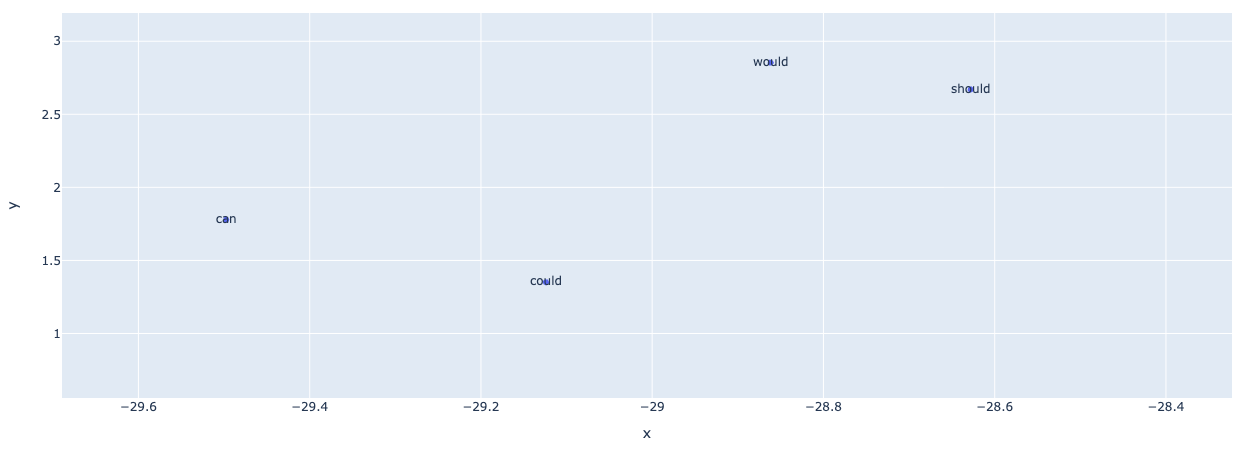

#### Si subimos el MAX_WORDS=400, se robustecen nuevos grupos
Números y tiempo

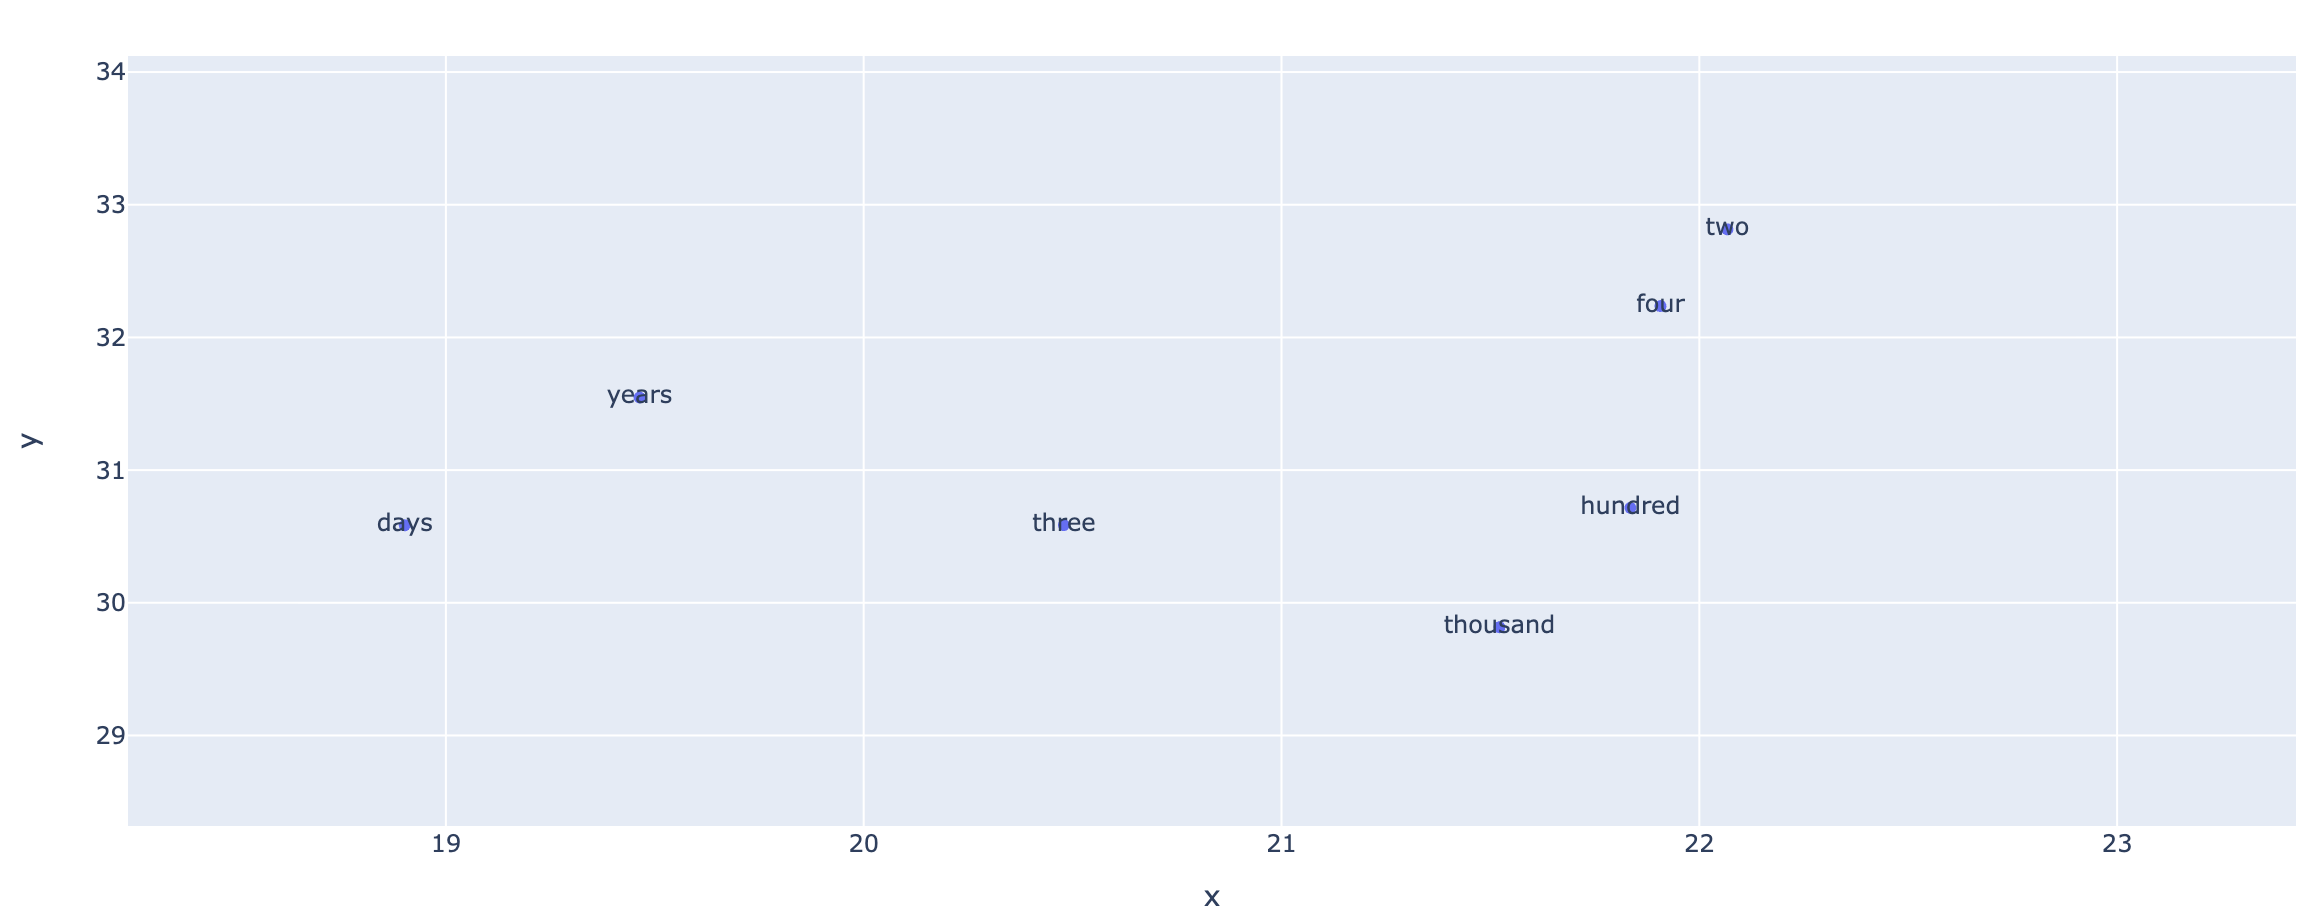

Hablando de Dulcinea

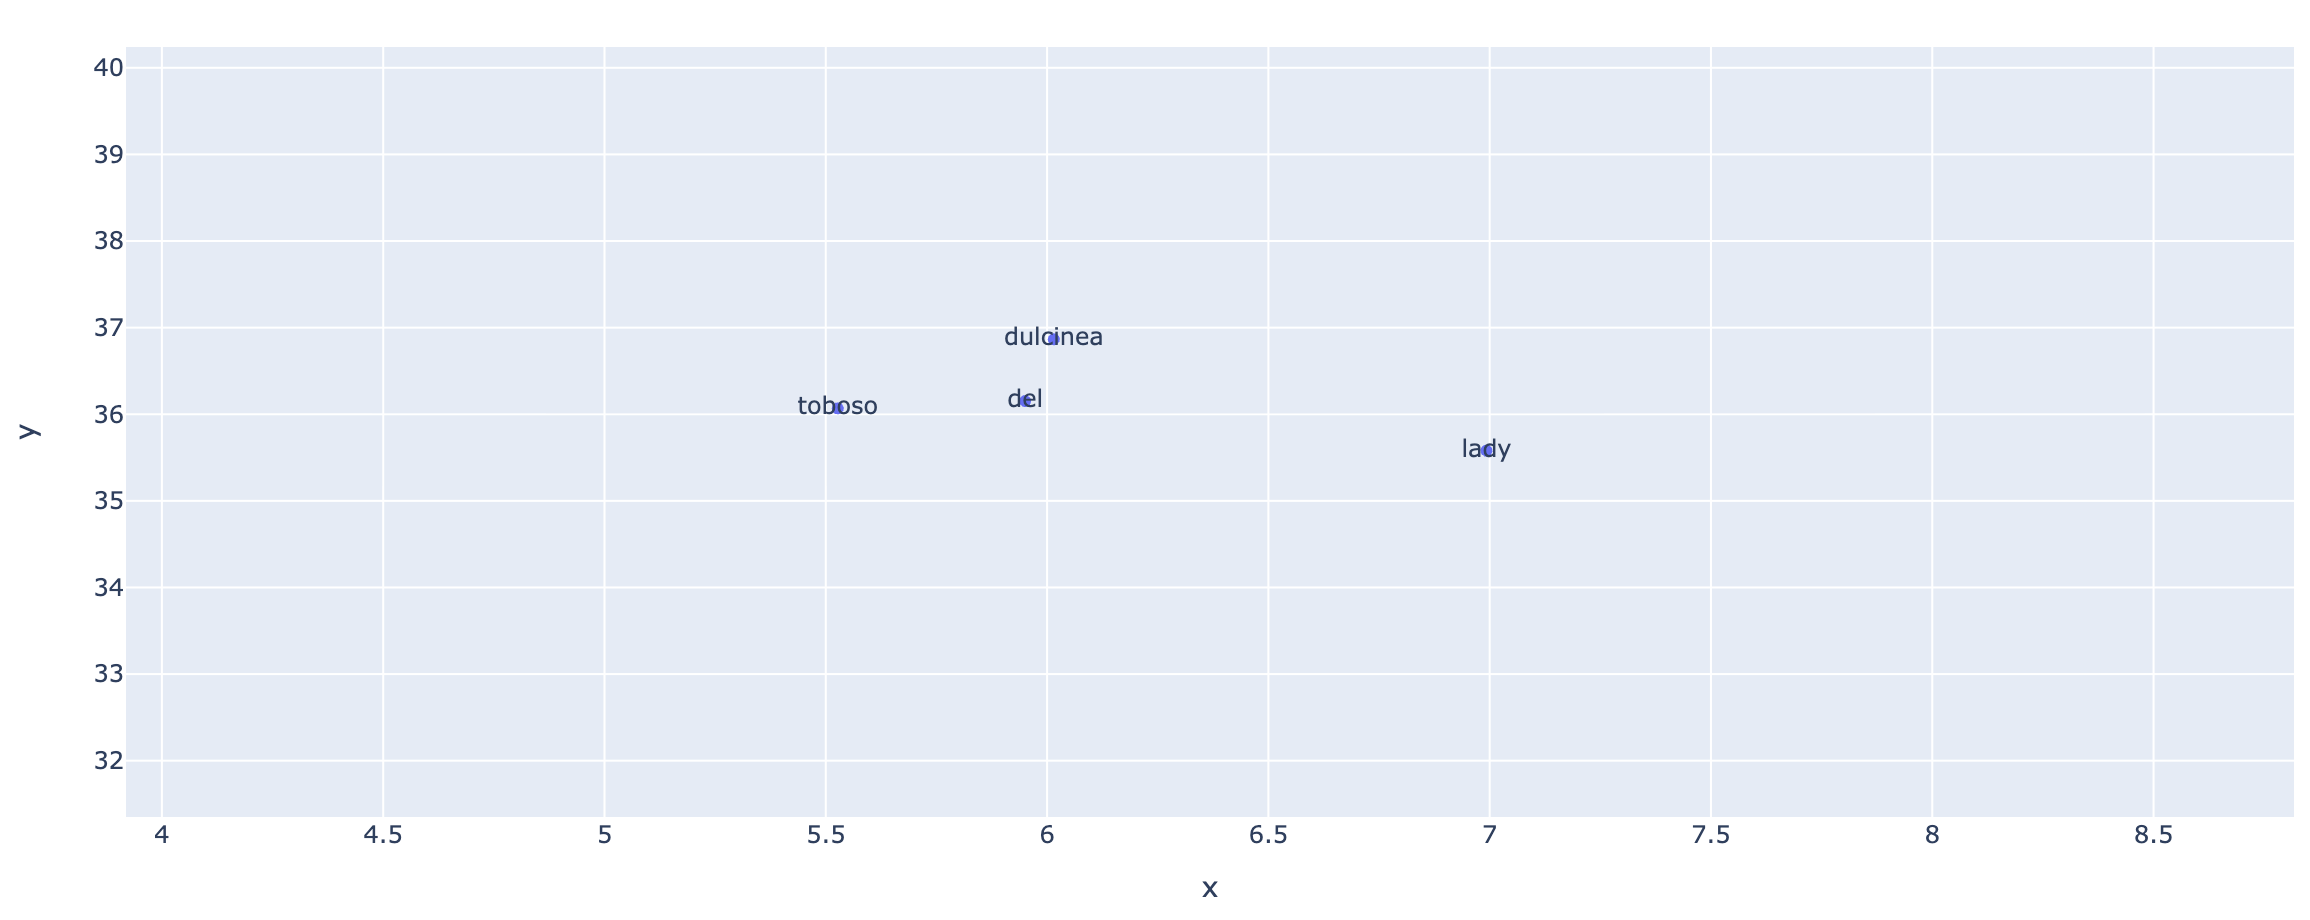